# deep neural networks from scratch

In [1]:
import os
import struct
import numpy as np
import pandas as pd
import sys

from scipy.special import expit

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### load mnist

In [2]:
def load_mnist(path, kind='train'):
    kind = 't10k' if kind=='test' else kind
    labels_path = os.path.join(path, '{}-labels-idx1-ubyte'.format(kind))
    img_path = os.path.join(path, '{}-images-idx3-ubyte'.format(kind))
    
    with open(labels_path, 'rb') as label_p:
        magic, n = struct.unpack('>II', label_p.read(8))
        labels = np.fromfile(label_p, dtype=np.uint8)
        
    with open(img_path, 'rb') as img_p:
        magic, n, rows, cols = struct.unpack('>IIII', img_p.read(16))
        images = np.fromfile(img_p, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

# train
X_train, y_train = load_mnist('./mnist/', kind='train')
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [3]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [4]:
(X_train[0]/256).reshape(28, 28)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [5]:
X_test, y_test = load_mnist('./mnist/', kind='test')

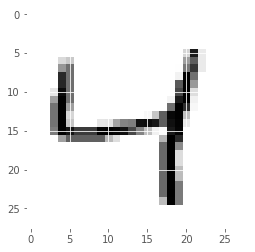

In [6]:
img_test = (X_train[2]/256).reshape(28, 28)
plt.imshow(img_test, cmap='Greys')

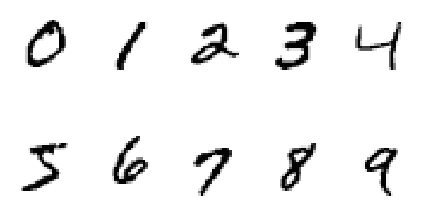

In [7]:
# get example of all numbers

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

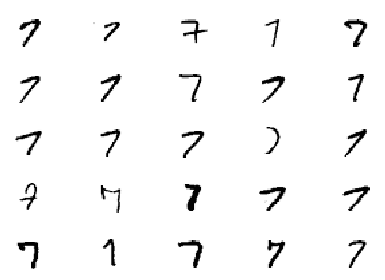

In [8]:
# get many examples of 1 number

def show_examples_of_number(n, length=5, width=5):
    fig, ax = plt.subplots(nrows=length, ncols=width, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(length*width):
        img = X_train[y_train == n][i].reshape(28,28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
# test
show_examples_of_number(7)

# multi-layer perceptron from scratch

In [9]:
class NueralNetMLP(object):
    
    def __init__(self, n_output, n_features, 
                 n_hidden=30, l1=0.0, l2=0.0, epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
        self.hidden_weights, self.output_weights = self._initialize_weights()
    
    
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    
    def _initialize_weights(self):
        hidden_weights = np.random.uniform(-1.0, 1.0, size=(self.n_hidden * (self.n_features + 1)))\
            .reshape(self.n_hidden, (self.n_features + 1))
        output_weights = np.random.uniform(-1.0, 1.0, size=(self.n_output * (self.n_hidden + 1)))\
            .reshape(self.n_output, (self.n_hidden + 1))
        return hidden_weights, output_weights
    
    
    def _sigmoid(self, z):
        return expit(z) # == 1 / (1 + np.exp(-z))
    
    
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('must be row or column')
        return X_new
    
    
    def _feedforward(self, X, hidden_weights, output_weights):
        a1 = self._add_bias_unit(X, how='column')
        
        z2 = hidden_weights.dot(a1.T)
        a2 = self._add_bias_unit(self._sigmoid(z2), how='row')
        
        z3 = output_weights.dot(a2)
        a3 = self._sigmoid(z3)
        
        return a1, z2, a2, z3, a3
    
    
    def _L2_reg(self, lambda_, hidden_weights, output_weights):
        penalty_hidden_weights = np.sum(hidden_weights[:, 1:] ** 2)
        penalty_output_weights = np.sum(output_weights[:, 1:] ** 2)
        return (lambda_/2.0) * (penalty_hidden_weights + penalty_output_weights)
    
    
    def _L1_reg(self, lambda_, hidden_weights, output_weights):
        penalty_hidden_weights = np.abs(hidden_weights[:, 1:]).sum()
        penalty_output_weights = np.abs(output_weights[:, 1:]).sum()
        return (lambda_/2.0) * (penalty_hidden_weights + penalty_output_weights)
    
    
    def _get_cost(self, y_enc, output, hidden_weights, output_weights):
        err_class0 = -y_enc * (np.log(output))
        err_class1 = -(1 - y_enc) * np.log(1 - output)
        cost = np.sum(err_class0 + err_class1)
        
        l1 = self._L1_reg(self.l1, hidden_weights, output_weights)
        l2 = self._L2_reg(self.l2, hidden_weights, output_weights)
        cost += l1 + l2
        
        return cost
    
    
    def _get_gradient(self, a1, a2, a3, z2, y_enc, hidden_weights, output_weights):
        # backprop
        err3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        err2 = output_weights.T.dot(err3) * self._sigmoid_gradient(z2)
        err2 = err2[1:, :]
        gradient1 = err2.dot(a1)
        gradient2 = err3.dot(a2.T)
        
        # regularize
        gradient1[:, 1:] += (hidden_weights[:, 1:] * (self.l1 + self.l2))
        gradient2[:, 1:] += (output_weights[:, 1:] * (self.l1 + self.l2))
        
        return gradient1, gradient2
    
    
    def fit(self, X, y, print_progress=True):
        # inits
        self.costs_ = []
        X_data, y_data = X.copy(), y.copy()
        
        delta_hidden_weight_prev = np.zeros(self.hidden_weights.shape)
        delta_output_weight_prev = np.zeros(self.output_weights.shape)
        
        # encode
        y_enc = self._encode_labels(y, self.n_output)

        # epoch loop
        for i in range(self.epochs):
            self.epoch_costs_ = []
            
            # adapt learning rate
            self.eta /= (1 + self.decrease_const*i)

            # shuffle data    
            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx_shuffle], y_enc[:, idx_shuffle]
            
            # batch loop
            minibatch = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in minibatch:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.hidden_weights, self.output_weights)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                     output=a3,
                                     hidden_weights=self.hidden_weights,
                                     output_weights=self.output_weights)
                self.costs_.append(cost)
                self.epoch_costs_.append(cost)
                
                # backpropagation
                gradient1, gradient2 = self._get_gradient(a1, a2, a3, z2, 
                                                          y_enc=y_enc[:, idx],
                                                          hidden_weights=self.hidden_weights, 
                                                          output_weights=self.output_weights)
                # update weights
                delta_hidden_weights = self.eta * gradient1
                delta_output_weights = self.eta * gradient2
                self.hidden_weights -= (delta_hidden_weights + (self.alpha * delta_hidden_weight_prev))
                self.output_weights -= (delta_output_weights + (self.alpha * delta_output_weight_prev))
                delta_hidden_weight_prev = delta_hidden_weights
                delta_output_weight_prev = delta_output_weights
                
            
            if print_progress:
                print('epoch:\t{} of {}\tmean cost:\t{}'.format(i+1, self.epochs, np.mean(self.epoch_costs_)))
                
        return self
    
    
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.hidden_weights, self.output_weights)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

In [10]:
nn_mlp = NueralNetMLP(n_output=10, 
                   n_features=X_train.shape[1], 
                   n_hidden=50, 
                   l1=0.0, 
                   l2=0.1, 
                   epochs=1000, 
                   eta=0.001, 
                   alpha=0.001, 
                   decrease_const=0.00001, 
                   shuffle=True, 
                   minibatches=50)

nn_mlp.fit(X_train, y_train)

epoch:	1 of 1000	mean cost:	4107.495017950327
epoch:	2 of 1000	mean cost:	2498.858160003062
epoch:	3 of 1000	mean cost:	2248.641313710714
epoch:	4 of 1000	mean cost:	2112.342726519208
epoch:	5 of 1000	mean cost:	2045.7246349766015
epoch:	6 of 1000	mean cost:	1935.579114985407
epoch:	7 of 1000	mean cost:	1855.653235723428
epoch:	8 of 1000	mean cost:	1837.199454220126
epoch:	9 of 1000	mean cost:	1802.3605152112477
epoch:	10 of 1000	mean cost:	1726.8477437413617
epoch:	11 of 1000	mean cost:	1722.8778202161175
epoch:	12 of 1000	mean cost:	1699.8828968671007
epoch:	13 of 1000	mean cost:	1658.6576232902644
epoch:	14 of 1000	mean cost:	1624.9951761652392
epoch:	15 of 1000	mean cost:	1596.1684743938374
epoch:	16 of 1000	mean cost:	1607.8737168024363
epoch:	17 of 1000	mean cost:	1604.4413372790752
epoch:	18 of 1000	mean cost:	1546.0592819283947
epoch:	19 of 1000	mean cost:	1578.3244845995503
epoch:	20 of 1000	mean cost:	1523.3707771430666
epoch:	21 of 1000	mean cost:	1483.6165928683354
epoch:	2

epoch:	173 of 1000	mean cost:	871.9801312079259
epoch:	174 of 1000	mean cost:	880.2969062382915
epoch:	175 of 1000	mean cost:	850.6563650319767
epoch:	176 of 1000	mean cost:	853.3114698435952
epoch:	177 of 1000	mean cost:	849.5364052396782
epoch:	178 of 1000	mean cost:	859.8114843433732
epoch:	179 of 1000	mean cost:	882.6519242589228
epoch:	180 of 1000	mean cost:	858.745779579262
epoch:	181 of 1000	mean cost:	852.9543623125163
epoch:	182 of 1000	mean cost:	848.8098838210535
epoch:	183 of 1000	mean cost:	833.262433593148
epoch:	184 of 1000	mean cost:	850.3203541880613
epoch:	185 of 1000	mean cost:	816.394117101332
epoch:	186 of 1000	mean cost:	822.1315936747702
epoch:	187 of 1000	mean cost:	824.0972609739787
epoch:	188 of 1000	mean cost:	844.9351686472127
epoch:	189 of 1000	mean cost:	873.936312801787
epoch:	190 of 1000	mean cost:	869.1098233311881
epoch:	191 of 1000	mean cost:	835.4553426911594
epoch:	192 of 1000	mean cost:	822.0699017267581
epoch:	193 of 1000	mean cost:	818.4776177580

epoch:	344 of 1000	mean cost:	655.2532042971636
epoch:	345 of 1000	mean cost:	653.7651912881964
epoch:	346 of 1000	mean cost:	657.6645377370297
epoch:	347 of 1000	mean cost:	651.0012356342883
epoch:	348 of 1000	mean cost:	646.6754756038592
epoch:	349 of 1000	mean cost:	646.8503070256379
epoch:	350 of 1000	mean cost:	648.6136789931438
epoch:	351 of 1000	mean cost:	684.6079987375549
epoch:	352 of 1000	mean cost:	659.081777284324
epoch:	353 of 1000	mean cost:	655.4205841378405
epoch:	354 of 1000	mean cost:	652.6250990620133
epoch:	355 of 1000	mean cost:	666.0168314527368
epoch:	356 of 1000	mean cost:	673.2114233895506
epoch:	357 of 1000	mean cost:	643.5002364053652
epoch:	358 of 1000	mean cost:	630.0607236037337
epoch:	359 of 1000	mean cost:	629.3472571324005
epoch:	360 of 1000	mean cost:	640.1625205372029
epoch:	361 of 1000	mean cost:	640.3372897815741
epoch:	362 of 1000	mean cost:	629.2482709969157
epoch:	363 of 1000	mean cost:	619.8801737345473
epoch:	364 of 1000	mean cost:	627.2511157

epoch:	515 of 1000	mean cost:	506.4562096468972
epoch:	516 of 1000	mean cost:	509.4717670358079
epoch:	517 of 1000	mean cost:	508.3281447373639
epoch:	518 of 1000	mean cost:	502.73324357030475
epoch:	519 of 1000	mean cost:	505.1359130279589
epoch:	520 of 1000	mean cost:	509.55607573948345
epoch:	521 of 1000	mean cost:	498.35909228286874
epoch:	522 of 1000	mean cost:	497.1435944342822
epoch:	523 of 1000	mean cost:	498.6668564843851
epoch:	524 of 1000	mean cost:	495.0418315596199
epoch:	525 of 1000	mean cost:	491.2538407208016
epoch:	526 of 1000	mean cost:	490.3918375359841
epoch:	527 of 1000	mean cost:	500.1156877804217
epoch:	528 of 1000	mean cost:	503.8692979728114
epoch:	529 of 1000	mean cost:	497.90589609766363
epoch:	530 of 1000	mean cost:	494.6754567273489
epoch:	531 of 1000	mean cost:	497.8497112137439
epoch:	532 of 1000	mean cost:	496.4289272718343
epoch:	533 of 1000	mean cost:	492.8861536829187
epoch:	534 of 1000	mean cost:	487.5013576617272
epoch:	535 of 1000	mean cost:	488.94

epoch:	685 of 1000	mean cost:	406.11750803558164
epoch:	686 of 1000	mean cost:	409.7367283778211
epoch:	687 of 1000	mean cost:	404.02699947435184
epoch:	688 of 1000	mean cost:	402.90168144187885
epoch:	689 of 1000	mean cost:	405.6892373268127
epoch:	690 of 1000	mean cost:	403.02394563416965
epoch:	691 of 1000	mean cost:	400.73917979186
epoch:	692 of 1000	mean cost:	397.9111774427521
epoch:	693 of 1000	mean cost:	396.5721871509038
epoch:	694 of 1000	mean cost:	397.5720905999263
epoch:	695 of 1000	mean cost:	399.16484004367436
epoch:	696 of 1000	mean cost:	401.55112946848453
epoch:	697 of 1000	mean cost:	400.5228208953629
epoch:	698 of 1000	mean cost:	400.1432187073098
epoch:	699 of 1000	mean cost:	398.7482969768077
epoch:	700 of 1000	mean cost:	397.65008781651704
epoch:	701 of 1000	mean cost:	395.4311342253001
epoch:	702 of 1000	mean cost:	394.46799056920406
epoch:	703 of 1000	mean cost:	393.492177745208
epoch:	704 of 1000	mean cost:	391.5591279287419
epoch:	705 of 1000	mean cost:	394.0

epoch:	855 of 1000	mean cost:	355.376410011001
epoch:	856 of 1000	mean cost:	355.33985432453517
epoch:	857 of 1000	mean cost:	355.2929331726562
epoch:	858 of 1000	mean cost:	355.25512960197557
epoch:	859 of 1000	mean cost:	355.20777221303115
epoch:	860 of 1000	mean cost:	355.1716501399715
epoch:	861 of 1000	mean cost:	355.1386534433176
epoch:	862 of 1000	mean cost:	355.07857485265214
epoch:	863 of 1000	mean cost:	355.07037707349133
epoch:	864 of 1000	mean cost:	355.04855744137916
epoch:	865 of 1000	mean cost:	355.05695255958517
epoch:	866 of 1000	mean cost:	354.9309181787943
epoch:	867 of 1000	mean cost:	354.8966550681541
epoch:	868 of 1000	mean cost:	355.00359332202356
epoch:	869 of 1000	mean cost:	354.7737190985788
epoch:	870 of 1000	mean cost:	354.78735873974756
epoch:	871 of 1000	mean cost:	354.8875527502481
epoch:	872 of 1000	mean cost:	354.81448387581935
epoch:	873 of 1000	mean cost:	354.7001067499859
epoch:	874 of 1000	mean cost:	354.62901462999804
epoch:	875 of 1000	mean cost:	

Text(0.5,0,'epoch x minibatch')

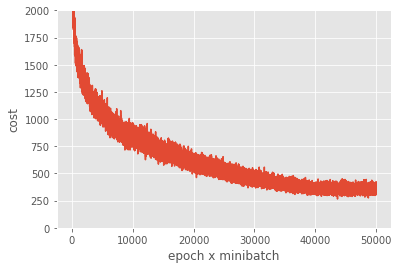

In [11]:
plt.plot(range(len(nn_mlp.costs_)), nn_mlp.costs_)

plt.ylim([0, 2000])
plt.ylabel('cost')
plt.xlabel('epoch x minibatch')

Text(0.5,0,'epochs')

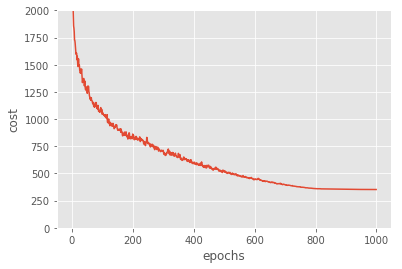

In [12]:
minibatches = np.array_split(range(len(nn_mlp.costs_)), 1000)
cost_ary = np.array(nn_mlp.costs_)
epoch_costs = [np.mean(cost_ary[i]) for i in minibatches]

plt.plot(range(len(epoch_costs)), epoch_costs)

plt.ylim([0, 2000])
plt.ylabel('cost')
plt.xlabel('epochs')

In [13]:
# training accuracy
np.sum(y_train == nn_mlp.predict(X_train)) / X_train.shape[0]

0.9777833333333333

In [14]:
# test accuracy
np.sum(y_test == nn_mlp.predict(X_test)) / X_test.shape[0]

0.9587

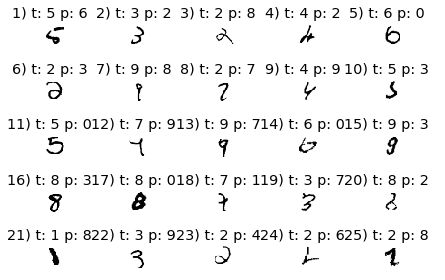

In [21]:
# inspect misclassified images
y_test_pred = nn_mlp.predict(X_test)
N = 25

misclass_img = X_test[y_test != y_test_pred][:N]
correct_class = y_test[y_test != y_test_pred][:N]
misclass = y_test_pred[y_test != y_test_pred][:N]

fig, ax = plt.subplots(nrows=5,
                      ncols=5,
                      sharex=True,
                      sharey=True)
ax = ax.flatten()
for i in range(N):
    img = misclass_img[i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('{}) t: {} p: {}  '.format(i+1, correct_class[i], misclass[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()